In [ ]:
!pip install netcdf4
!pip install xarray
!pip install minisom
!pip install sklearn
!pip install cartopy
import xarray as xr
import netCDF4
import numpy as np
import pandas as pd
from minisom import MiniSom
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from google.colab import drive
drive.mount("/content/gdrive")

import os
#os.listdir('/content/drive/MyDrive/ERA5 598 Data')

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Mounted at /content/gdrive


You need to create a new folder that will include your netcdf4 file that you need to upload directly after manually downloading it. Make sure that your google colab drive is mounted as done in the previous code block, or this will not work.

In [ ]:
path = "/content/gdrive/MyDrive/ERA5 598 Data/"
os.makedirs(path, exist_ok=True)

nc_path = "/content/gdrive/MyDrive/ERA5 598 Data/new_combined_era5_data.nc"


# output directory to save SOMs
folderpath = '/content/gdrive/MyDrive/final_SOMs_output/'

# create directory
os.makedirs(folderpath, exist_ok=True)

Open dataset using xarray and view variables, coordinates

In [ ]:
ds = xr.open_dataset(nc_path, engine="netcdf4")

print(ds['pv'])

<xarray.DataArray 'pv' (valid_time: 1104, pressure_level: 1, latitude: 293,
                        longitude: 73)> Size: 94MB
[23613456 values with dtype=float32]
Coordinates:
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 2kB 50.0 49.75 49.5 ... -22.75 -23.0
  * longitude       (longitude) float64 584B -105.0 -104.8 ... -87.25 -87.0
  * valid_time      (valid_time) datetime64[ns] 9kB 1940-06-01 ... 2023-08-31
Attributes: (12/31)
    GRIB_paramId:                             60
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      21389
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           pv
    GRIB_totalNumber:                         0
    GRIB_units:                               K m**2 kg**-1 

Data preparation of ERA5 NetCDF4 dataset

In [ ]:
# set variables for geopotential, convert it to geopotential height by dividing by gravity (m^2/s^2 --> m)
z500 = ds['z'] / 9.80665

# set variable for potential vorticity
pv = ds['pv']

# convert from PV to PVU
pv_pvu = ds['pv'].squeeze() * 1e6

#print(pv_pvu)

# save values of time, lat and lon from dataset
time_values = ds['valid_time'].values
lat = ds['latitude'].values
lon = ds['longitude'].values

Unit testing for data preparation

In [ ]:
def test_unit_conversion():
    z500 = ds['z'] / 9.80665
    pv_pvu = ds['pv'].squeeze() * 1e6
    assert np.isfinite(z500.values).all()

print(test_unit_conversion())

None


Putting PVU and Z500 into two engineered features for input into SOM

Allows us to detect repeating spatial regimes, including our blocking events, using input that is easier to train model and visualize on.

Sources: https://uw.pressbooks.pub/ocean285/chapter/pgf-and-d-gradient/
https://pmc.ncbi.nlm.nih.gov/articles/PMC6936472/

In [ ]:
# get radians for lat and lon, caluclate the spacing
deg2rad = np.pi / 180.0
Re = 6.371e6
lat_vals = pv_pvu.latitude.values
lon_vals = pv_pvu.longitude.values
lat_rad = lat_vals * deg2rad
mean_lat_rad = np.mean(lat_rad)

# get grid spacing in meters
dlat_m = np.gradient(lat_vals) * deg2rad * Re
dlon_m = np.gradient(lon_vals) * deg2rad * Re * np.cos(mean_lat_rad)

# compute horizontal gradient of the 500 hPa PVU field wrt to lat and lon (spatially scaled to distance --> PVU)
dpv_dlat = pv_pvu.differentiate(coord='latitude') / dlat_m[:, np.newaxis]
dpv_dlon = pv_pvu.differentiate(coord='longitude') / dlon_m[np.newaxis, :]

# find the magnitude and mean across field
pv_grad_mag = np.sqrt(dpv_dlat**2 + dpv_dlon**2)
pv_grad_mean = pv_grad_mag.mean(dim=["latitude", "longitude"]).squeeze().values

# compute horizontal gradient of the 500 hPa geopotential height field wrt to lat and lon
dz_dlat = z500.differentiate(coord='latitude') / dlat_m[:, np.newaxis]
dz_dlon = z500.differentiate(coord='longitude') / dlon_m[np.newaxis, :]

# find the magnitude and mean across field
z500_grad_mag = np.sqrt(dz_dlat**2 + dz_dlon**2)
z500_grad_mean = z500_grad_mag.mean(dim=["latitude", "longitude"]).squeeze().values

# puts PVU gradient, Z gradient into single matrix to create SOM training datasets
X = np.stack([pv_grad_mean, z500_grad_mean], axis=1)


The data needs to be normalized in order too

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def normalization_selection(pv_grad_mean, z500_grad_mean):
    # combine into matrix
    X = np.stack([pv_grad_mean, z500_grad_mean], axis=1)

    # min-max scaling
    min_val = np.min(X)
    max_val = np.max(X)
    scale_factor = 100.0 / (max_val - min_val)
    X_minmax = X * scale_factor

    # Z-score scaling
    X_zscore = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # compare standard deviation ratios of scaled variables to find which method is more balanced (closer to 1)
    std_ratio_minmax = np.std(X_minmax[:, 0]) / np.std(X_minmax[:, 1])
    std_ratio_zscore = np.std(X_zscore[:, 0]) / np.std(X_zscore[:, 1])

    # pick method where std ratio is closest to 1
    if abs(std_ratio_minmax - 1) < abs(std_ratio_zscore - 1):
        method_used = 'minmax'
    else:
        method_used = 'zscore'

    return method_used

scaling_method = normalization_selection(pv_grad_mean, z500_grad_mean)
print(scaling_method)

zscore


In [ ]:
# initialize StandardScaler
scaler = StandardScaler()

# fit the scaler to the data and transform it to standardize it
X_scaled = scaler.fit_transform(X)

print(f"Scaled data:\n{X_scaled}")
print(f"Scaled data shape: {X_scaled.shape}")

Scaled data:
[[-2.32539345 -0.51131468]
 [-2.13611354 -0.777404  ]
 [-1.35461546 -0.8094    ]
 ...
 [ 0.49375698 -0.55430466]
 [-0.18173187 -1.45725808]
 [ 0.30041976 -0.95049727]]
Scaled data shape: (1104, 2)


Creating and training the SOMs using different hyperparameters to test for the best SOM.

Source: https://github.com/JustGlowing/minisom
https://github.com/taliakurtz/MiniSOM_tutorial/blob/main/MiniSOM_Tutorial_Step_2.ipynb

In [ ]:
# set hyperparameter combinations to loop over and create individual SOM models for comparison
param_combinations = [
    (3, 3, 1.0, 0.01),
    (3, 3, 1.0, 0.05),
    (3, 3, 2.0, 0.01),
    (3, 3, 2.0, 0.05),
    (3, 4, 1.0, 0.01),
    (3, 4, 1.0, 0.05),
    (3, 4, 2.0, 0.01),
    (3, 4, 2.0, 0.05),
    (4, 3, 1.0, 0.01),
    (4, 3, 1.0, 0.05),
    (4, 3, 2.0, 0.01),
    (4, 3, 2.0, 0.05),
    (4, 4, 1.0, 0.01),
    (4, 4, 1.0, 0.05),
    (4, 4, 2.0, 0.01),
    (4, 4, 2.0, 0.05),]

# set training data's input length
input_length = X_scaled.shape[1]

# set number of iterations for training each SOM
num_iterations = 100000

# empty list to store quantization and topographic errors for each SOM model
qerror_list = []
terror_list = []

#for storing best SOM after loop
best_som = None

# use for tracking highest QE and TE to determine whether next SOM is better than the previous best SOM
q_win = float('inf')
t_win = float('inf')

In [ ]:
import pickle

# for loop to iterate over all combinations of parameters defined in previous cod cell
for s in param_combinations:
    x, y, sigma, learning_rate = s

    print(f"\nTraining SOM with x={x}, y={y}, sigma={sigma}, LR={learning_rate}")

    # initialize SOM with each hyperparameter
    som = MiniSom(x=x, y=y, input_len=input_length, sigma=sigma, learning_rate=learning_rate, neighborhood_function='gaussian')

    # train SOM on the scaled data
    som.random_weights_init(X_scaled)
    som.train(X_scaled, num_iteration=num_iterations, random_order=True, verbose=True)

    # calculate quantization and topographic errors
    q_error = som.quantization_error(X_scaled)
    t_error = som.topographic_error(X_scaled)

    # append errors to empty list to compare values later
    qerror_list.append((x, y, sigma, learning_rate, q_error))
    terror_list.append((x, y, sigma, learning_rate, t_error))

    #print the errors
    print(f"QE = {q_error:.4f}, TE = {t_error:.4f}")

    # save SOM model into folder path with SOM hyperparameters
    filename = f'SOM_{x}x{y}_LR{learning_rate}_SIG{sigma}.p'
    with open(os.path.join(folderpath, filename), 'wb') as f:
        pickle.dump(som, f)

    # update best_som variable based on errors to determine what model had the lowest errors
    if (q_error < q_win) or (q_error == q_win and t_error < t_win):
        best_som = som
        q_win = q_error
        t_win = t_error

# summarize the best SOM from those tested
print(f"\nBest SOM: QE = {q_win:.4f}, TE = {t_win:.4f}")


Training SOM with x=3, y=3, sigma=1.0, LR=0.01
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5188033747817443
QE = 0.5188, TE = 0.0190

Training SOM with x=3, y=3, sigma=1.0, LR=0.05
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5259248407115589
QE = 0.5259, TE = 0.0118

Training SOM with x=3, y=3, sigma=2.0, LR=0.01
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.571686578512697
QE = 0.5717, TE = 0.0000

Training SOM with x=3, y=3, sigma=2.0, LR=0.05
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.5791218642326676
QE = 0.5791, TE = 0.0000

Training SOM with x=3, y=4, sigma=1.0, LR=0.01
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.4500365439302544
QE = 0.4500, TE = 0.0181

Training SOM with x=3, y=4, sigma=1.0, LR=0.05
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.44780454662140323
QE = 0.4478, TE = 0.1875

Training SOM with x=3, y=4, sigma=2.0, LR=0.01
 [ 100000 / 100000 ] 1

Save the best SOM model from loop

In [ ]:
best_model_path = os.path.join(folderpath, 'best_som_model.p')
with open(best_model_path, 'wb') as f:
    pickle.dump(best_som, f)

print(f"Best SOM model saved to: {best_model_path}")

Best SOM model saved to: /content/gdrive/MyDrive/final_SOMs_output/best_som_model.p


Your final plots will be saved to a new output file on your drive.


In [ ]:
with open('/content/gdrive/MyDrive/final_SOMs_output/best_som_model.p', 'rb') as file:
    som_model = pickle.load(file)

output_folder = '/content/gdrive/MyDrive/SOM_Plots_final/'
os.makedirs(output_folder, exist_ok=True)

Attach SOM node to time variable

   som_node  frequency
0       0_0         38
1       0_1         57
2       0_2         73
3       0_3         40
4       1_0         54
5       1_1         85
6       1_2         99
7       1_3         91
8       2_0         51
9       2_1         77
10      2_2         98
11      2_3         76
12      3_0         30
13      3_1         72
14      3_2         97
15      3_3         66


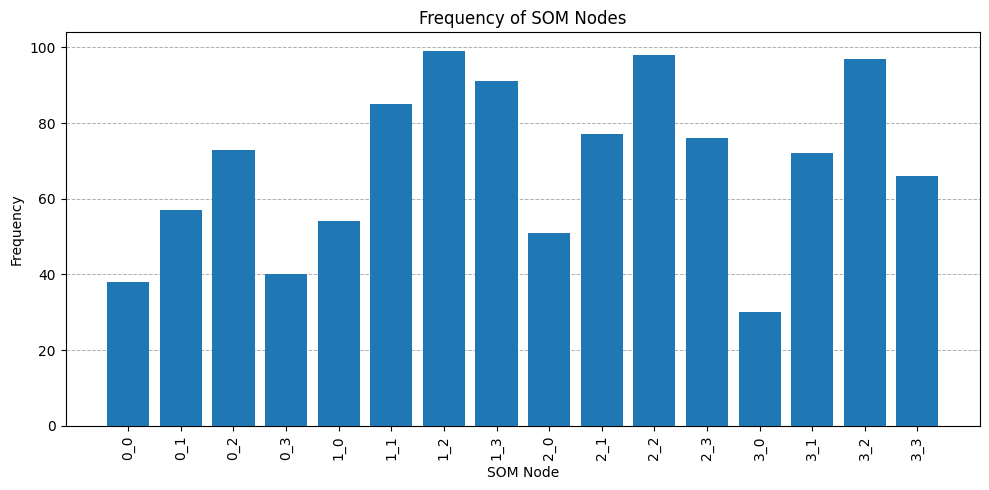

In [ ]:
# predict the BMUs for each time step using scaled data
bmus = np.array([best_som.winner(x) for x in X_scaled])

# convert BMUs to string labels to index and group
bmu_labels = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]

# add SOM labels and timesteps to dataframe
df_som = pd.DataFrame({"valid_time": pd.to_datetime(ds['valid_time'].values), "som_node": bmu_labels})

# count how many times each SOM node was the BMU
freq_counts = df_som['som_node'].value_counts().sort_index()

ds = ds.assign_coords(som_node=("valid_time", bmu_labels))

# convert to dataframe for visualizations
freq_df = freq_counts.reset_index()
freq_df.columns = ['som_node', 'frequency']

print(freq_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(freq_df['som_node'], freq_df['frequency'], zorder=3)
plt.title('Frequency of SOM Nodes')
plt.xlabel('SOM Node')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.grid(True, axis='y', linestyle='--', linewidth=0.7, zorder=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'som_node_frequency.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# create dictionary to store input samples for each node
from collections import defaultdict
node_inputs = defaultdict(list)

# loop through input samples and assign BMU
for i, bmu in enumerate(bmus):
    node_inputs[tuple(bmu)].append(X_scaled[i])

# compute mean input that went into each node
node_means = {node: np.mean(vals, axis=0) for node, vals in node_inputs.items()}

# empty lsit to store node data
rows = []

#for loop to convert turn values into string for pandas dataframe
for node, mean_vec in node_means.items():
    node_str = f"{node[0]}_{node[1]}"
    rows.append({"node": node_str, "mean_pv_grad": mean_vec[0], "mean_z500_grad": mean_vec[1]})

# put into pandas dataframe and save as csv
node_df = pd.DataFrame(rows)
node_df = node_df.sort_values(by="node")  # Optional: sort for readability
node_df.to_csv("som_node_mean_gradients_final.csv", index=False)

print(node_df)

   node  mean_pv_grad  mean_z500_grad
10  0_0      1.156295       -1.672495
11  0_1      1.142536       -0.573588
6   0_2     -0.527308        0.984888
8   0_3     -1.206644        1.776628
15  1_0      2.030119       -0.120062
13  1_1      0.689908        0.053932
3   1_2     -0.588707        0.088714
7   1_3     -1.425604        0.287740
12  2_0      1.567967        1.054575
5   2_1      0.087941        0.345631
1   2_2     -0.479596       -0.604766
0   2_3     -1.291229       -0.978540
14  3_0      0.571804        2.458288
4   3_1      0.487956        1.076605
2   3_2      0.200711       -0.734149
9   3_3     -0.241229       -1.615048


In [ ]:
# create dictionary
node_fields = defaultdict(list)   # key = SOM node, value = spatial fields of Z500 and PV assigned to node

# loop through time steps and BMUs and append field
for i, bmu in enumerate(bmus):
    node_fields[tuple(bmu)].append(z500[i, :, :].values)   # add field to list of fields for node

# set empty list to append mean node fields
node_mean_fields = {}

# for loop to stack the fields of each SOMnode and calculate mean, appending to dictionary for mean spatial field
for node, fields in node_fields.items():
  stacked_fields = np.stack(fields, axis=0)
  mean_field = np.mean(stacked_fields, axis=0)
  node_mean_fields[node] = mean_field


pv_grad_fields = defaultdict(list)

for i, bmu in enumerate(bmus):
    pv_grad_fields[tuple(bmu)].append(pv_grad_mag[i, :, :].values)

mean_pv_grad_fields = {}
for node, fields in pv_grad_fields.items():
    stacked = np.stack(fields, axis=0)
    mean_pv_grad = np.mean(stacked, axis=0)
    mean_pv_grad_fields[node] = mean_pv_grad

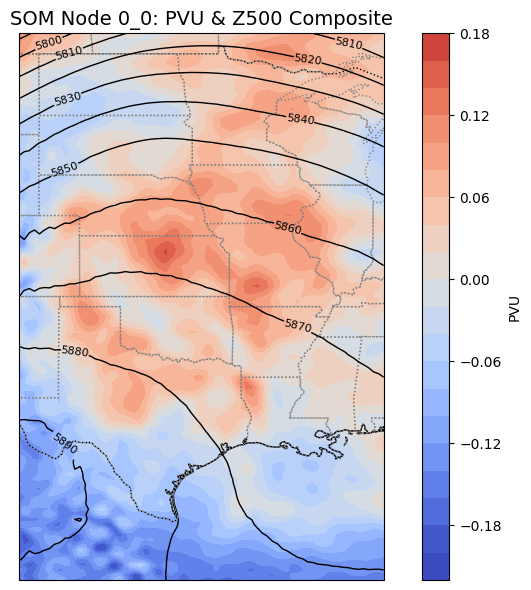

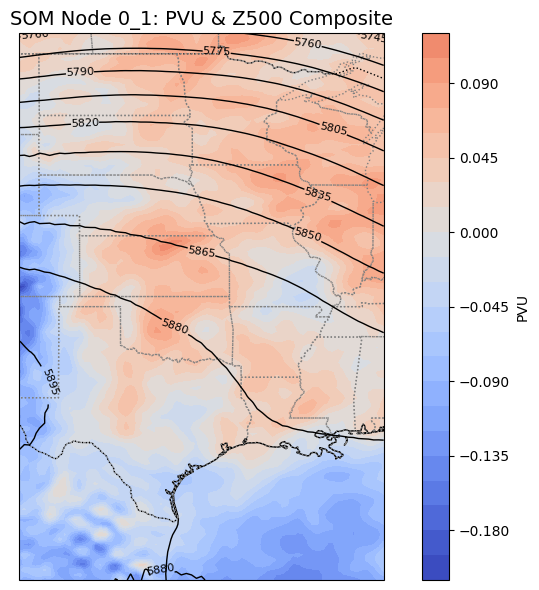

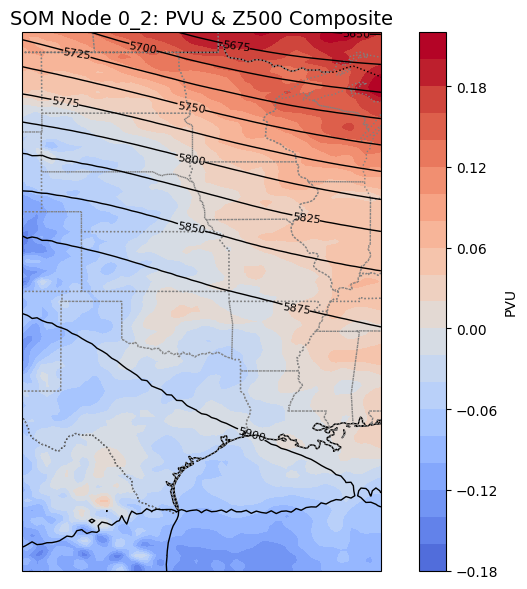

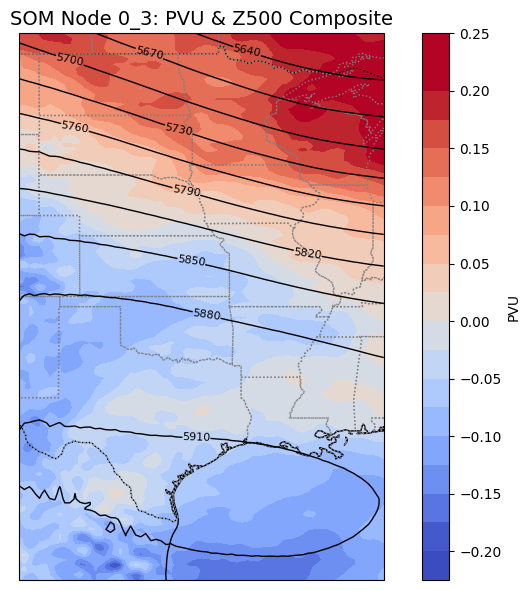

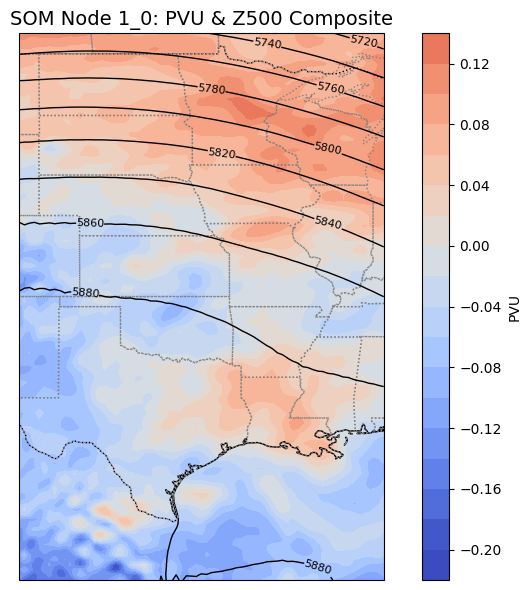

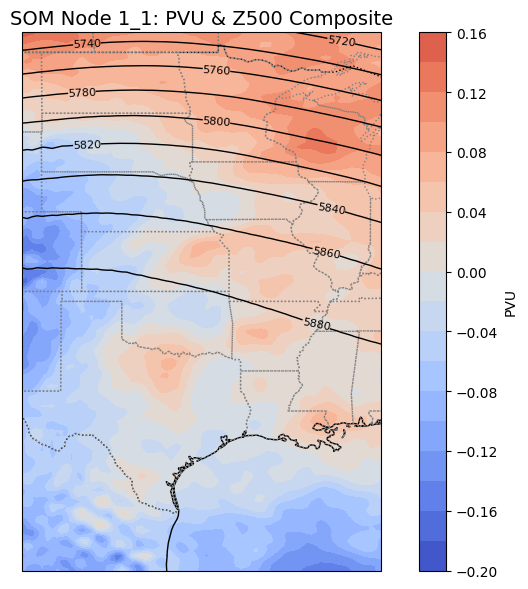

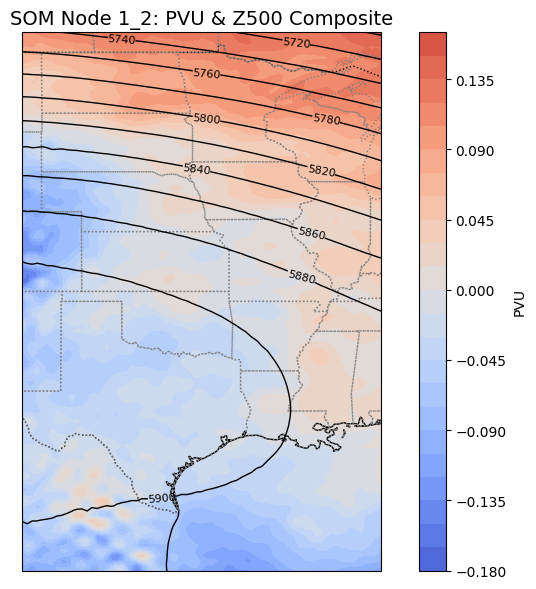

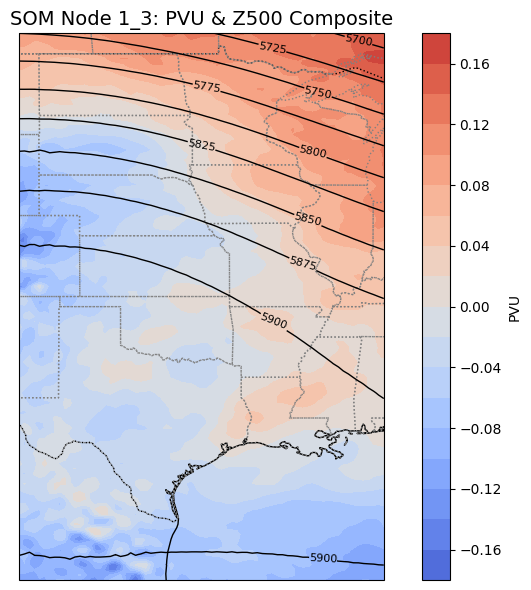

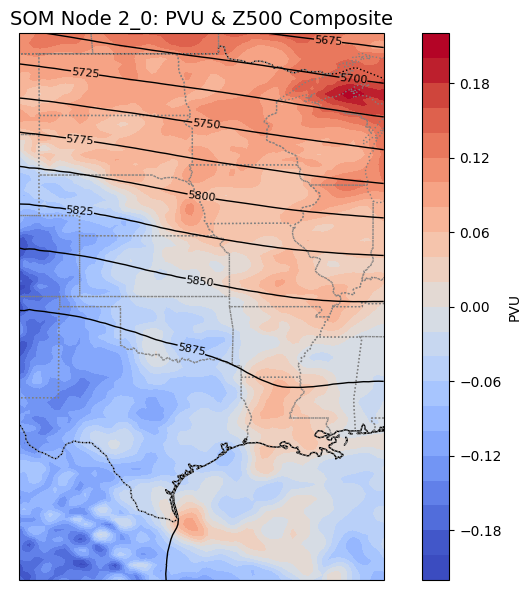

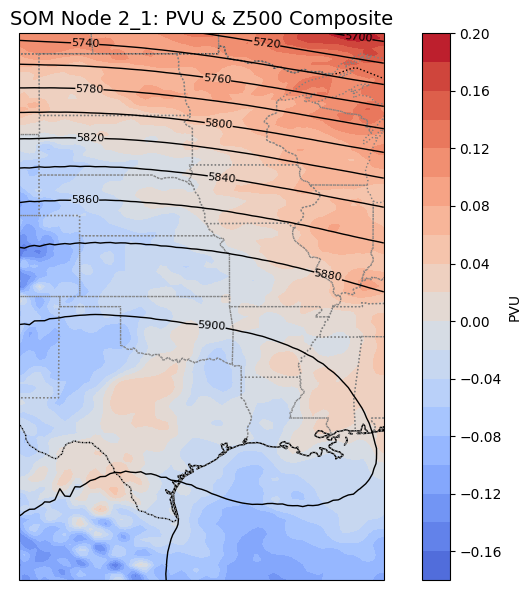

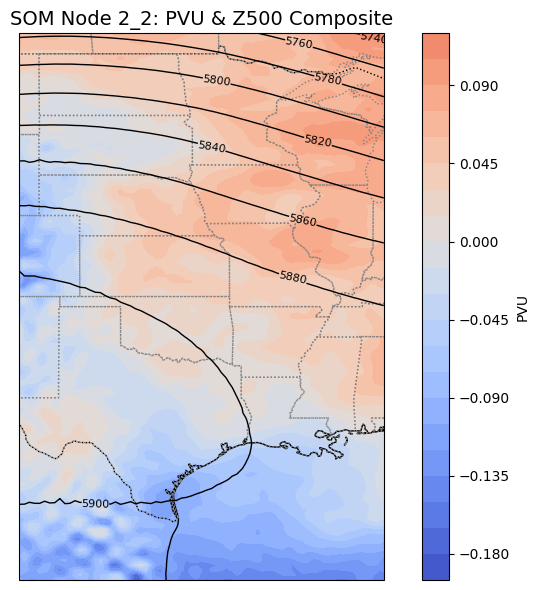

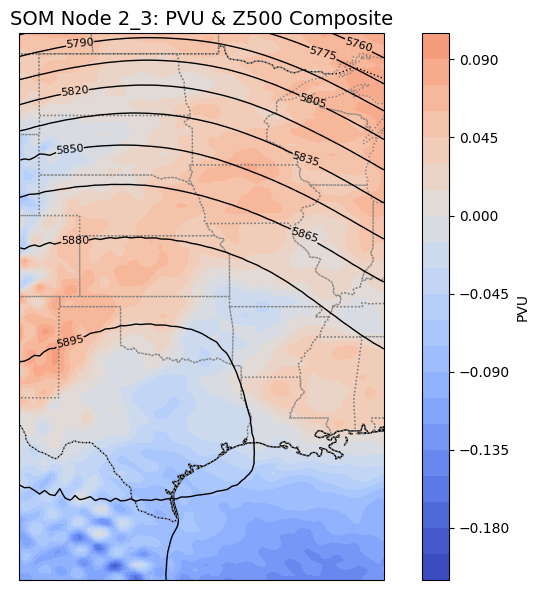

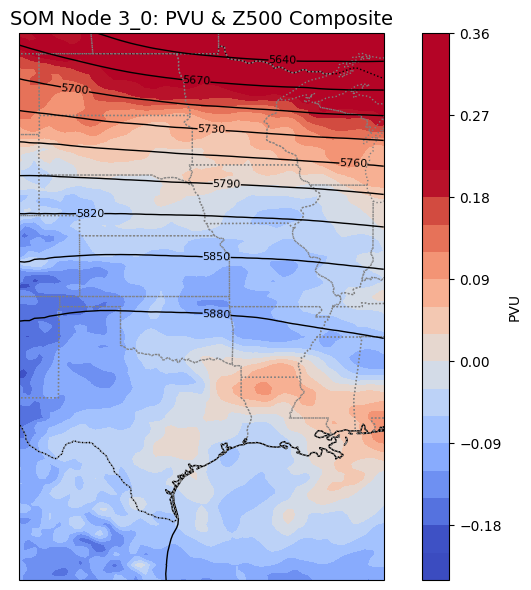

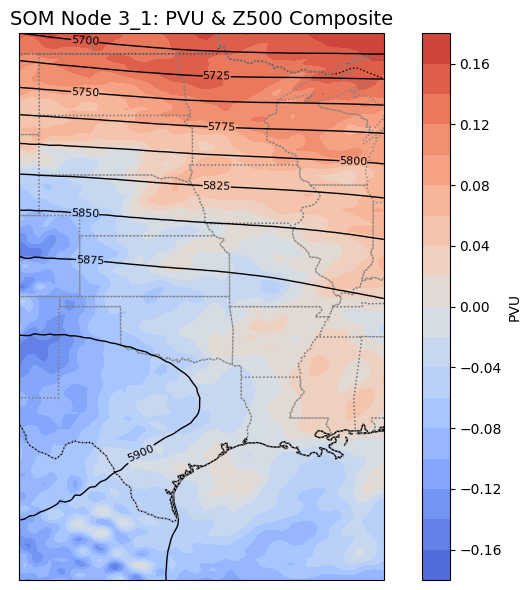

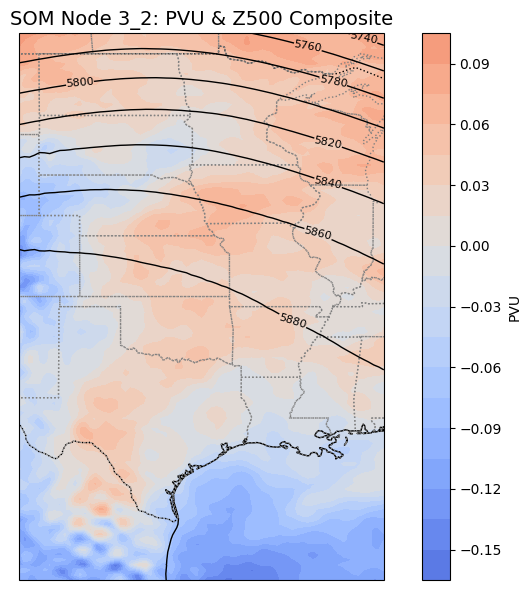

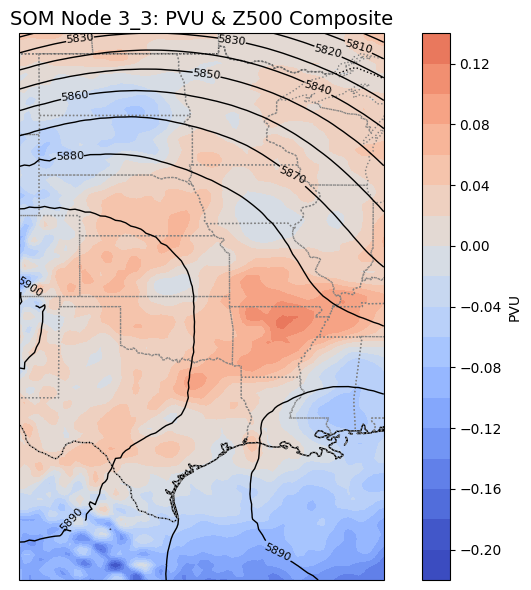

In [ ]:

# find unqiue SOM nodes
nodes = np.unique(ds['som_node'].values)

# get min/max of PVU across all nodes for plotting same range of values in for loop (typical values at 500 hpa is 0.01 to 1 PVU)
pv_min = pv_pvu.min().item()
pv_max = pv_pvu.max().item()
pv_mean_global = pv_pvu.mean().item()

#loop through som nodes
for node in nodes:
    # grab subsets of z500 valeues for each time step and SOM node
    z500_subset = z500.sel(valid_time=ds['valid_time'][ds['som_node'] == node])
    #calculate mean for composite map
    z500_mean = z500_subset.sel(pressure_level=500).mean(dim='valid_time')
    #subset region
    z500_roi = z500_mean.sel(latitude=slice(50, 23), longitude=slice(-105, -87))
    # grab subsets of PV valeues for each time step and SOM node
    pv_subset = pv_pvu.sel(valid_time=ds['valid_time'][ds['som_node'] == node])
    #calculate mean for composite map
    pv_mean = pv_subset.mean(dim='valid_time')
    #subset region
    pv_roi = pv_mean.sel(latitude=slice(50, 23), longitude=slice(-105, -87))
    # plot PVU anomalies
    pv_anomaly = pv_roi - pv_roi.mean().item()

    # plot both PVU and Z500 on same figure
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_title(f"SOM Node {node}: PVU & Z500 Composite", fontsize=14)

    # add filled contours for PVU
    p = ax.contourf(pv_roi['longitude'], pv_roi['latitude'], pv_anomaly, levels=21, cmap='coolwarm', transform=ccrs.PlateCarree(), vmin=-0.2, vmax=0.2)
    plt.colorbar(p, ax=ax, orientation='vertical', label='PVU')

    # add line contours for z500
    z = ax.contour(z500_roi['longitude'], z500_roi['latitude'], z500_roi, levels=10, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(z, inline=True, fontsize=8)
    # set map extent, add otherfeatures
    ax.set_extent([-105, -87, 23, 50], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    plt.tight_layout()
    node_str = node if isinstance(node, str) else f"{node[0]}_{node[1]}"
    filename = os.path.join(output_folder, f"SOM_Node_{node_str}_anomaly_composite_final.png")
    plt.savefig(filename, dpi=300)

    plt.show()

In [ ]:
print(pv_min)
print(pv_max)

-4.4637603759765625
5.894366264343262


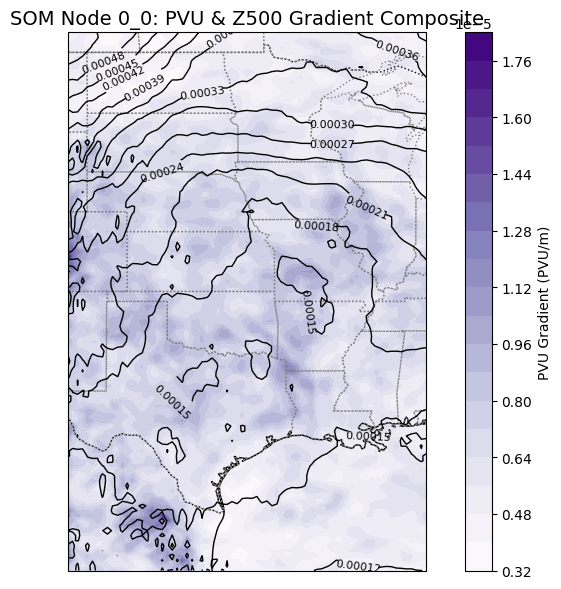

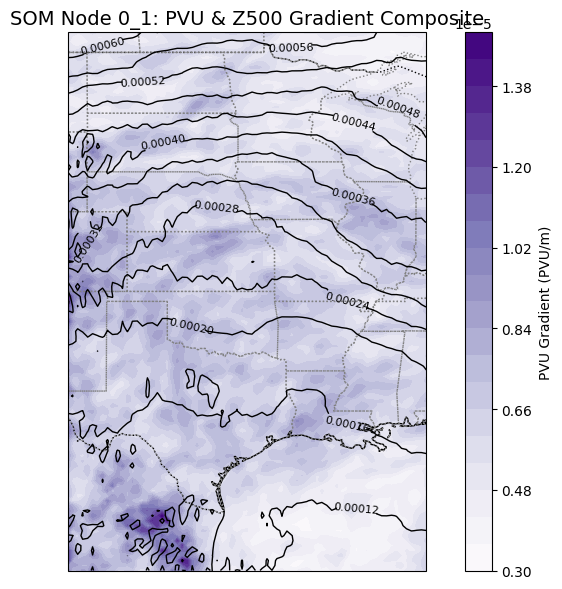

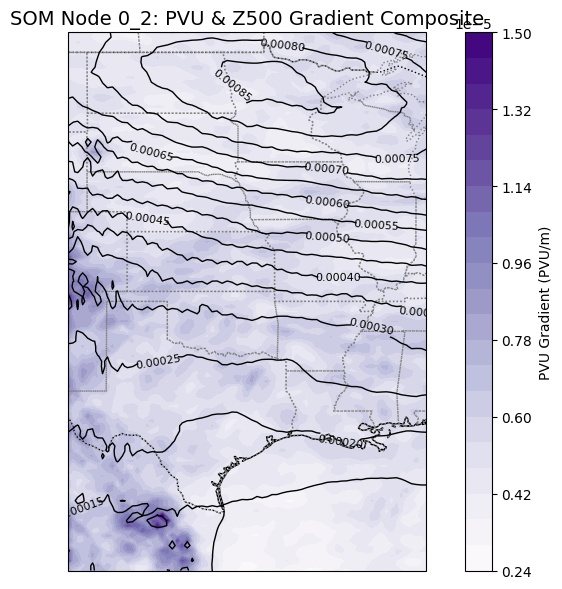

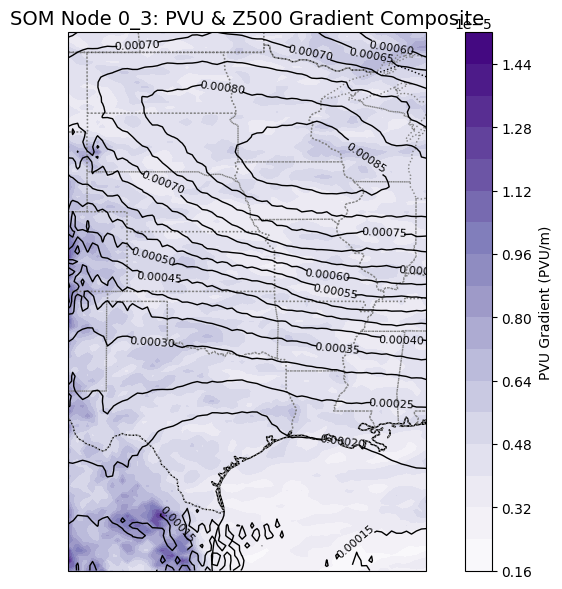

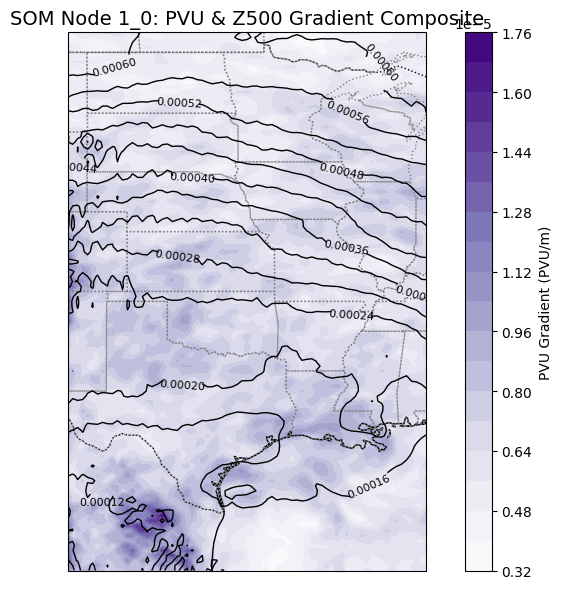

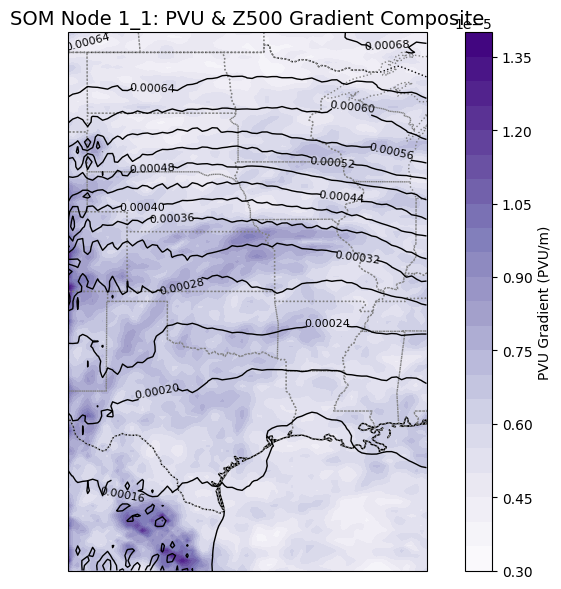

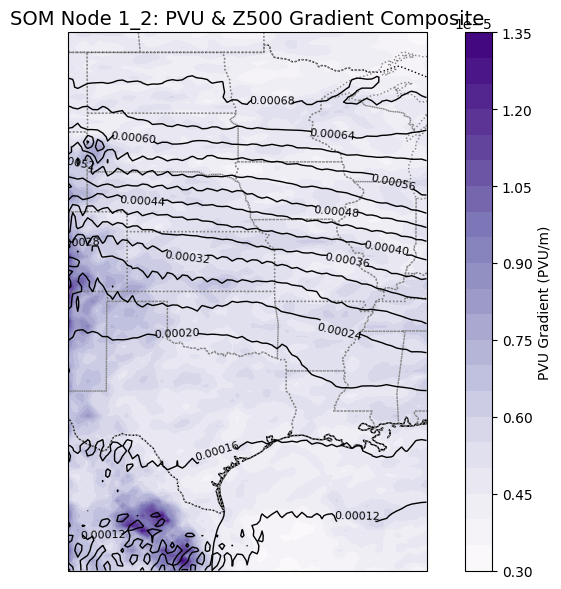

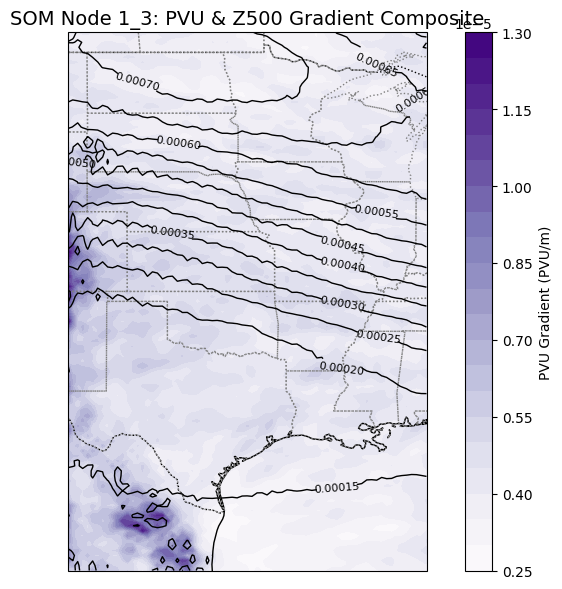

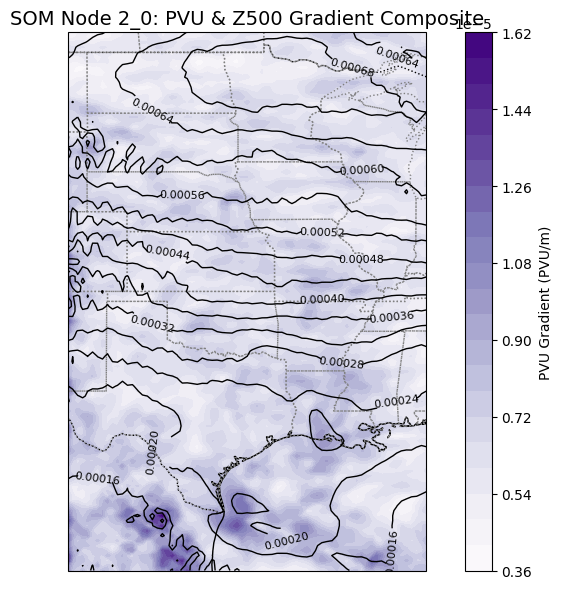

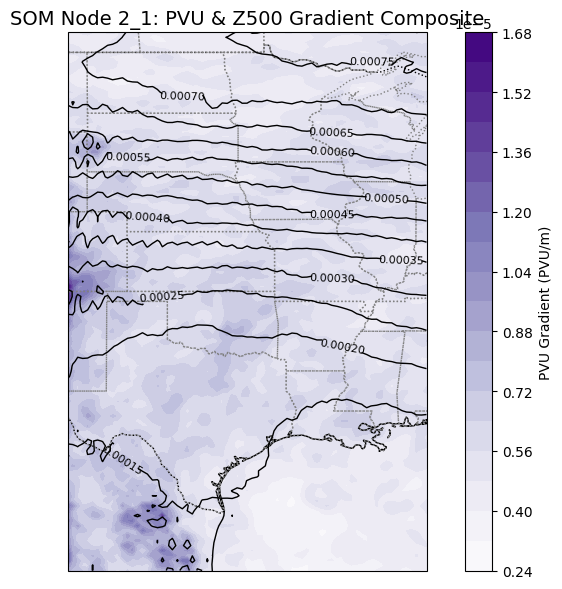

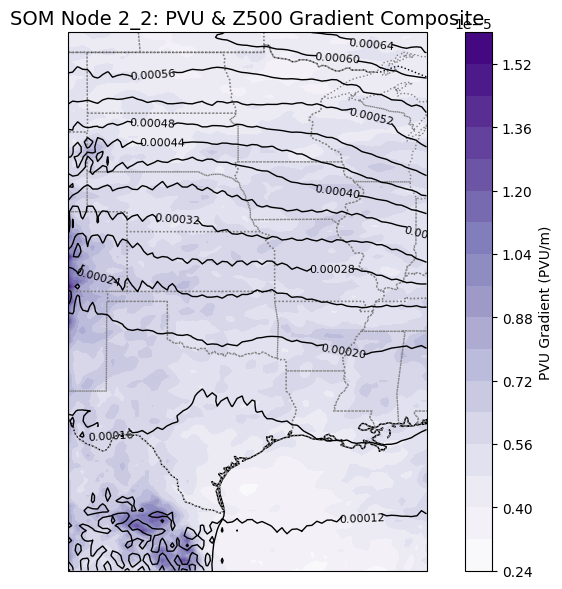

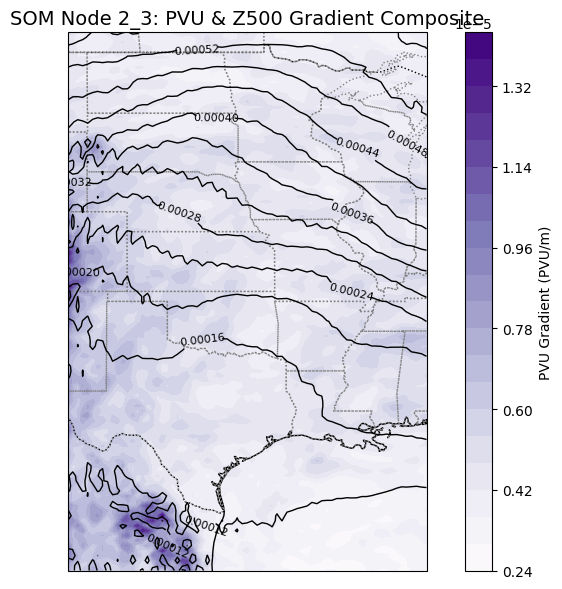

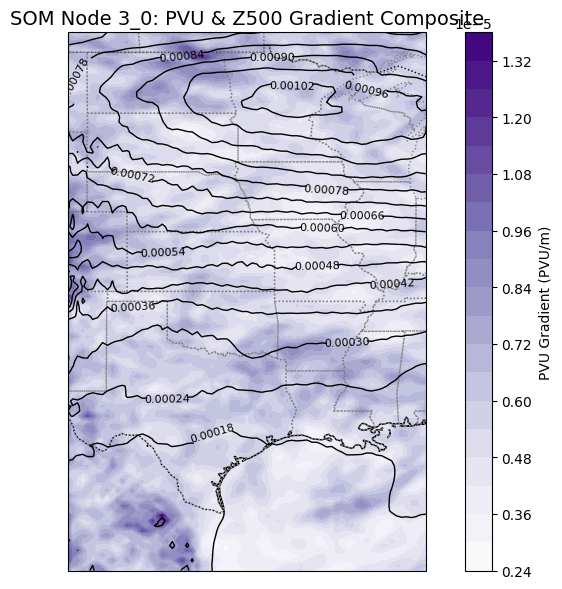

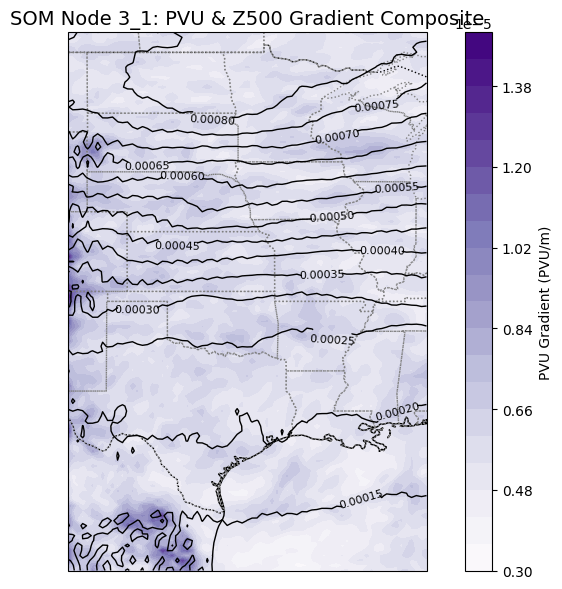

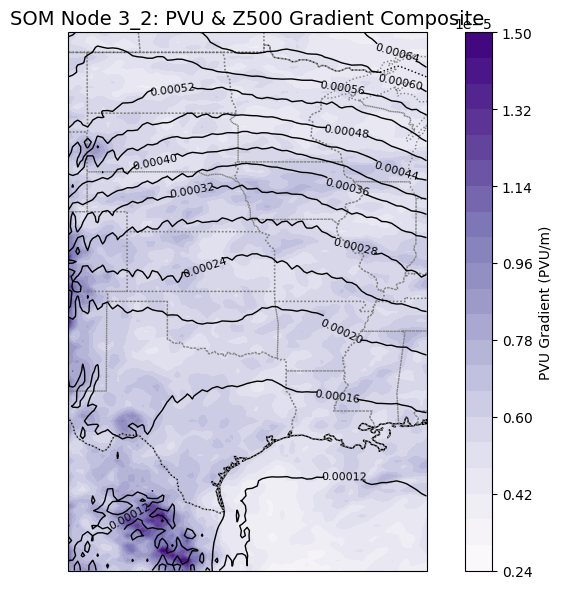

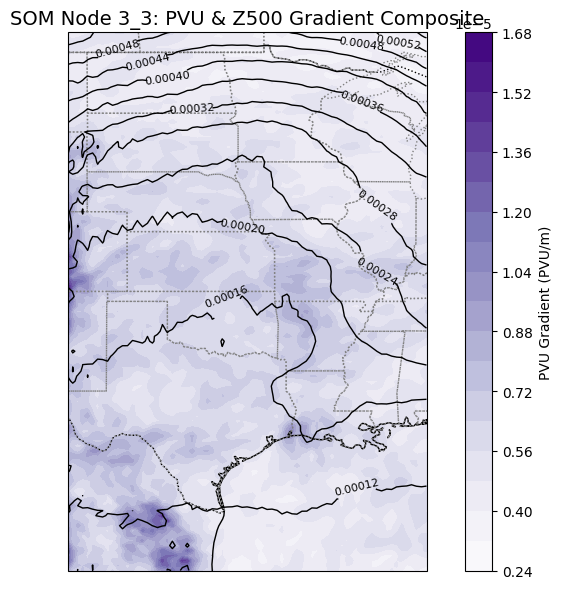

In [ ]:
# loop through each SOM node to plot the gradient fields together
for node in np.unique(ds['som_node'].values):

    # subset valid time for nodes
    mask = ds['som_node'].values == node
    times = ds['valid_time'].values[mask]

    # subset gradient fields
    pv_grad_composite = pv_grad_mag.sel(valid_time=times).mean(dim='valid_time')
    z500_grad_composite = z500_grad_mag.sel(valid_time=times).mean(dim='valid_time')

    # select only region of interest
    pv_grad_roi = pv_grad_composite.sel(latitude=slice(50, 23), longitude=slice(-105, -87))
    z500_grad_roi = z500_grad_composite.sel(latitude=slice(50, 23), longitude=slice(-105, -87))

    # Ensure both fields are now 2D arrays
    pv_grad_2d = pv_grad_roi.squeeze()
    z500_grad_2d = z500_grad_roi.squeeze()

    # create plots
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_title(f"SOM Node {node}: PVU & Z500 Gradient Composite", fontsize=14)

    # set PVU gradient contours
    p = ax.contourf(pv_grad_2d['longitude'], pv_grad_2d['latitude'], pv_grad_2d, levels=20, cmap='Purples', transform=ccrs.PlateCarree())
    plt.colorbar(p, ax=ax, orientation='vertical', label='PVU Gradient (PVU/m)')

    # set Z500 gradient contour lines
    z = ax.contour(z500_grad_2d['longitude'], z500_grad_2d['latitude'], z500_grad_2d, levels=15, colors='black', linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(z, inline=True, fontsize=8)

    ax.set_extent([-105, -87, 23, 50], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linestyle=':', edgecolor='gray')

    plt.tight_layout()
    node_str = node if isinstance(node, str) else f"{node[0]}_{node[1]}"
    filename = os.path.join(output_folder, f"SOM_Node_{node_str}_gradient_composite_final.png")
    plt.savefig(filename, dpi=300)

    plt.show()

In [ ]:
# see the counts of days assigned to each SOM node
df_som['som_node'].value_counts().sort_values(ascending=False)

som_node
1_2    99
2_2    98
3_2    97
1_3    91
1_1    85
2_1    77
2_3    76
0_2    73
3_1    72
3_3    66
0_1    57
1_0    54
2_0    51
0_3    40
0_0    38
3_0    30
Name: count, dtype: int64

In [ ]:
# grab time coordinate from xarray dataset to link SOM nodes to their date
dates = ds['valid_time'].values

# convert into string labels for indexing
bmu_labels = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]

# create a pandas dataframe that will connect BMU/SOM node to its date
df = pd.DataFrame({"valid_time": pd.to_datetime(dates), "bmu": bmu_labels})

# create new column som_node in xarray data that puts each time with SOM nodel label
ds = ds.assign_coords(som_node=("valid_time", bmu_labels))

ds

<xarray.Dataset> Size: 189MB
Dimensions:         (valid_time: 1104, pressure_level: 1, latitude: 293,
                     longitude: 73)
Coordinates:
  * pressure_level  (pressure_level) float64 8B 500.0
  * latitude        (latitude) float64 2kB 50.0 49.75 49.5 ... -22.75 -23.0
  * longitude       (longitude) float64 584B -105.0 -104.8 ... -87.25 -87.0
  * valid_time      (valid_time) datetime64[ns] 9kB 1940-06-01 ... 2023-08-31
    som_node        (valid_time) <U3 13kB '2_3' '2_3' '2_3' ... '3_3' '3_2'
Data variables:
    z               (valid_time, pressure_level, latitude, longitude) float32 94MB ...
    pv              (valid_time, pressure_level, latitude, longitude) float32 94MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-01T21:43 GRIB to CDM+CF via cfgrib-0.9.1...

Identify what SOM nodes represent blocking patterns using mean PV and z500 for each time step. Create a blocking detection method combining PV and z500 to flag the SOM nodes most likely to represent atmospheric blocking pattern regimes based on threshold of top 20%.

Sources: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html



In [ ]:
# create dataframe from standardized input data used in the SOM
X_df = pd.DataFrame(X_scaled, columns=["pv_grad_mean", "z500_grad_mean"])

# add SOM BMU labels as a string
X_df["bmu"] = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]

# calculate the mean of the features (mean PV gradient, z500 gradient) that were grouped into each SOM/BMU node and put it into new dataframe
mean_features = X_df.groupby("bmu").mean()

# make a new dataframe of mean_features to do the scaling for blocking score
mean_features_scaled = mean_features.copy()

# initialize scaler
scaler = StandardScaler()

# scale features using sklearn function that standardizes features on same scale with mean = 0 and std = 1
mean_features_scaled[["pv_grad_mean", "z500_grad_mean"]] = scaler.fit_transform(mean_features[["pv_grad_mean", "z500_grad_mean"]])

# assign blocking score to mean_features dataframe that includes:
# 1. low PV gradient, where weaker gradient is associated with onset of blocking (more negative, higher blocking score)
# 2. z500 gradient mean, where weaker geopotential height gradients associated with blocked flow (more negative, higher blocking score)
# higher score = more likely the node is representing a blocking pattern
mean_features_scaled["blocking_score"] = -mean_features_scaled["pv_grad_mean"] + -mean_features_scaled["z500_grad_mean"]

# set threshold for score for blockings score where values > 20%
score_thresh = mean_features_scaled["blocking_score"].quantile(0.80)

# select all SOM nodes where the blocking_score is above this threshold
blocking_nodes = mean_features_scaled[mean_features_scaled["blocking_score"] > score_thresh].index.tolist()

print("Blocking nodes:", blocking_nodes)

Blocking nodes: ['1_3', '2_3', '3_3']


In [ ]:
import json

def identify_blocking_nodes(X_scaled, bmus, output_path="blocking_nodes.json", save_json=True, verbose=True):
  # create dataframe from SOM output
  X_df = pd.DataFrame(X_scaled, columns=["pv_grad_mean", "z500_grad_mean"])
  X_df["bmu"] = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]

  #compute mean gradient
  mean_features = X_df.groupby("bmu").mean()

  # stanardize at each node
  scaler = StandardScaler()
  mean_features_scaled = mean_features.copy()
  mean_features_scaled[["pv_grad_mean", "z500_grad_mean"]] = scaler.fit_transform(mean_features[["pv_grad_mean", "z500_grad_mean"]])

  # compute vlocking score (high means more blocked-like pattern)
  mean_features_scaled["blocking_score"] = (-mean_features_scaled["pv_grad_mean"] + -mean_features_scaled["z500_grad_mean"])
  # set 80th percentile threshold
  score_thresh = mean_features_scaled["blocking_score"].quantile(0.80)

  # get blocking nodes
  blocking_nodes = mean_features_scaled[mean_features_scaled["blocking_score"] > score_thresh].index.tolist()

  if verbose:
        print("Blocking nodes:", blocking_nodes)

  if save_json:
       with open(output_path, "w") as f:
            json.dump(blocking_nodes, f)

  return blocking_nodes


In [ ]:
blocking_nodes = identify_blocking_nodes(X_scaled, bmus)

Blocking nodes: ['1_3', '2_3', '3_3']


Label the SOM/BMUs as blocked or not blocked.

In [ ]:
# label the SOMs blocked or not blocked based on BMU from SOM
blocked_labels = [1 if f"{bmu[0]}_{bmu[1]}" in blocking_nodes else 0 for bmu in bmus]

#add column for blocked n/y (0/1) labels into pandas dataframe for classification
df_som['blocked'] = blocked_labels
ds = ds.assign_coords(blocked=("valid_time", blocked_labels))
df_som.groupby("blocked")['som_node'].value_counts()
df_som.to_csv("som_blocking_labels.csv", index=False)

View days that fall within the blocked dates identified by the SOM

In [ ]:
# group by node and blocked/not blocked
grouped_df = df_som.groupby(['blocked', 'som_node'])['valid_time'].apply(list)


In [ ]:
# pandas datetime
df_som['date'] = pd.to_datetime(df_som['valid_time'])
grouped_df

# use pandas .explode function to separate grouped_dfinto separate rows and flatten it
flat_df = grouped_df.explode().reset_index()
flat_df.columns = ['blocked', 'bmu', 'valid_time']

# explort to CSV to do manual analysis
flat_df.to_csv("blocked_events_bmu_f.csv", index=False)

Visualizations - SOM Node Frequency Maps

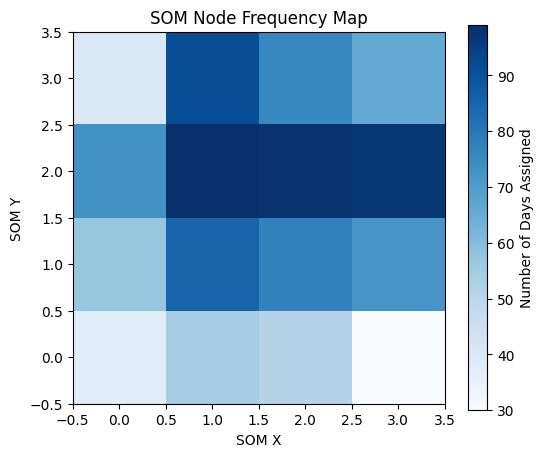

In [ ]:
# frewuency of SOM nodes
bmu_counts = pd.Series([f"{bmu[0]}_{bmu[1]}" for bmu in bmus]).value_counts()

# convert to 2D grid
grid = np.zeros((som.get_weights().shape[0], som.get_weights().shape[1]))

#for loop to fill 2D som grid with number of data points for each node
for label, count in bmu_counts.items():
    x, y = map(int, label.split('_'))
    grid[x, y] = count

# plot the node frequency maps
plt.figure(figsize=(6, 5))
plt.imshow(grid.T, origin='lower', cmap='Blues')
plt.title('SOM Node Frequency Map')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')
plt.colorbar(label='Number of Days Assigned')
plt.grid(False)

plt.savefig(os.path.join(output_folder, "som_node_frequency_map.png"))
plt.show()

Blocking frequency by year

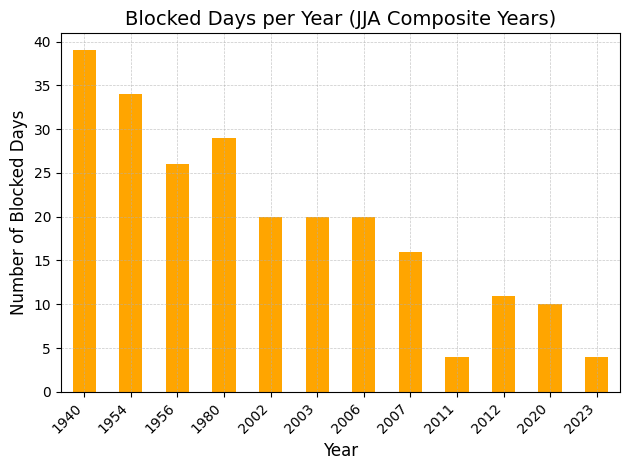

In [ ]:
# converts to pandas date time format
df_som['year'] = pd.to_datetime(df_som['valid_time']).dt.year

# groups som dataframe by year and sums total "blocked" days for each year
yearly_counts = df_som.groupby('year')['blocked'].sum()

#plot yearly count by number of blocked events per year
yearly_counts.plot(kind='bar', color='orange')

plt.title("Blocked Days per Year (JJA Composite Years)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Blocked Days", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "blocked_days_by_year.png"))
plt.show()

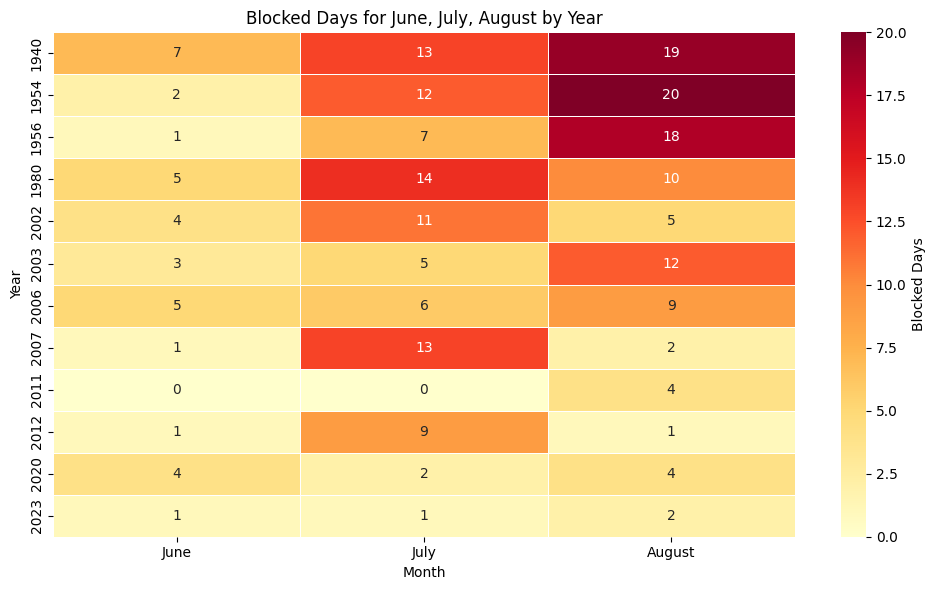

In [ ]:
import seaborn as sns

# datetime and select months, years from som_df
df_som['valid_time'] = pd.to_datetime(df_som['valid_time'])
df_som['year'] = df_som['valid_time'].dt.year
df_som['month'] = df_som['valid_time'].dt.month

#  JJA subset
df_jja = df_som[df_som['month'].isin([6, 7, 8])]

# group by year and month to sum blocked days
jja_blocked = df_jja.groupby(['year', 'month'])['blocked'].sum().unstack()

# create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(jja_blocked, cmap="YlOrRd", linewidths=0.5, annot=True, fmt=".0f", cbar_kws={'label': 'Blocked Days'})

# add figure features
plt.title("Blocked Days for June, July, August by Year")
plt.ylabel("Year")
plt.xlabel("Month")
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['June', 'July', 'August'], ha='center')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "blocked_days_heatmap.png"))
plt.show()

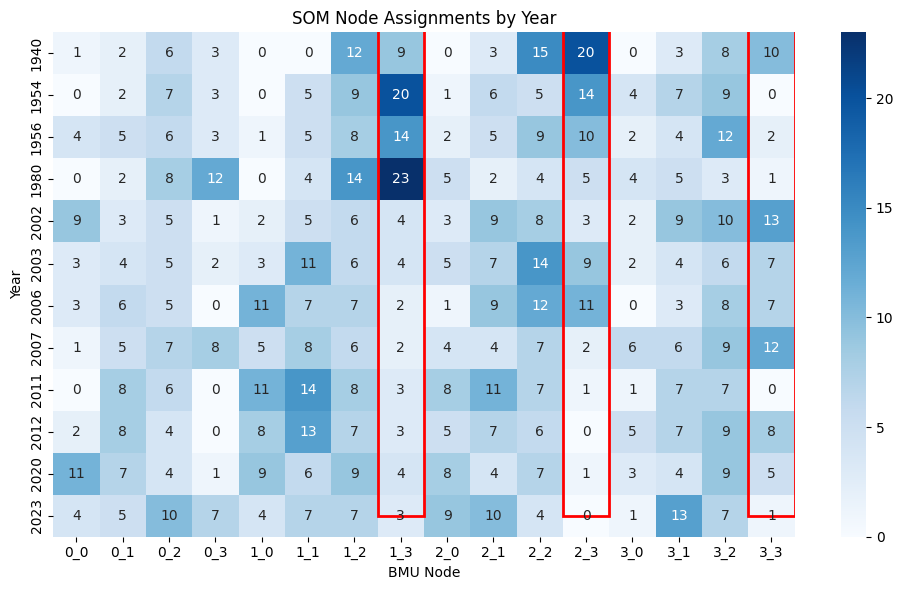

In [ ]:
import matplotlib.patches as patches
# group by year and som node, find how often each node was found for each year
heatmap_data = df_som.groupby(['year', 'som_node']).size().unstack(fill_value=0)

#plot the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt="d")

# specify blocked nodes for highlighting
blocking_nodes = blocking_nodes
highlight_cols = [col for col in heatmap_data.columns if col in blocking_nodes]

#draw box around node columns
for col in highlight_cols:
    x = heatmap_data.columns.get_loc(col)  # column index
    y = -0.5
    height = len(heatmap_data)
    rect = patches.Rectangle((x, y),width=1, height=height, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.title("SOM Node Assignments by Year")
plt.ylabel("Year")
plt.xlabel("BMU Node")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "SOM_node_assignments_by_year.png"))
plt.show()

U-Matrix to show average distance between SOM node and its neighboring nodes

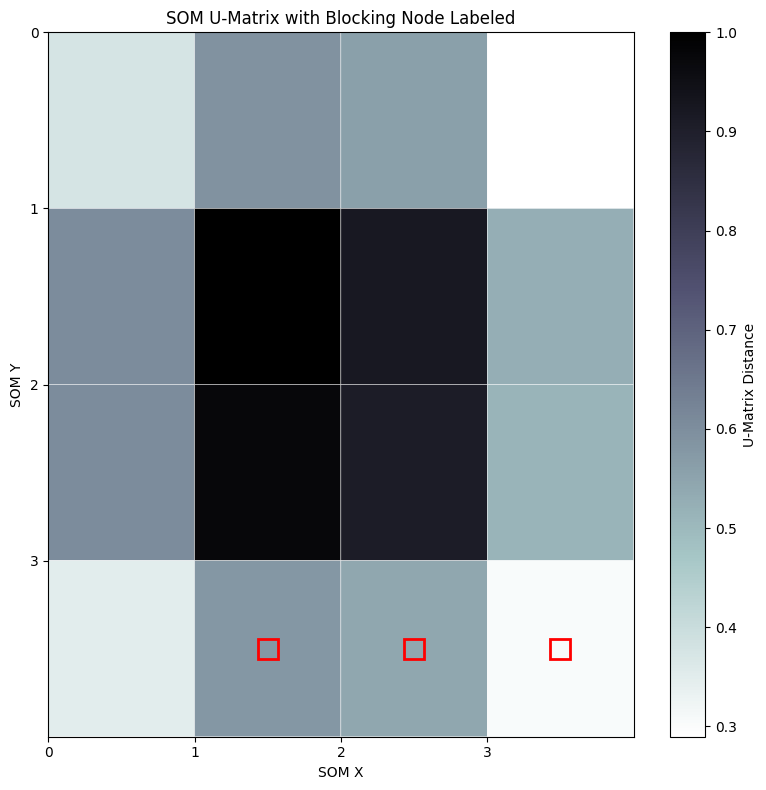

In [ ]:
# create umatrix to represent distance between node and its neighbors
u_matrix = som.distance_map().T

# create figure
plt.figure(figsize=(8, 8))
plt.pcolor(u_matrix, cmap='bone_r', edgecolors='white', linewidth=0.3)
plt.colorbar(label='U-Matrix Distance')
plt.title('SOM U-Matrix with Blocking Node Labeled')
plt.xlabel('SOM X')
plt.ylabel('SOM Y')

# lopp to overlay squares over blocking nodes
for node in blocking_nodes:
    x_str, y_str = node.split('_')
    x, y = int(x_str), int(y_str)
    plt.plot(x + 0.5, y + 0.5, 's', markerfacecolor='none',markeredgecolor='red', markersize=14, markeredgewidth=2)

# sets correct dimensions and aligns with som orientation
x_len, y_len = som.get_weights().shape[:2]
plt.xticks(np.arange(x_len))
plt.yticks(np.arange(y_len))
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(output_folder, "SOM_umatrix_node.png"))
plt.show()

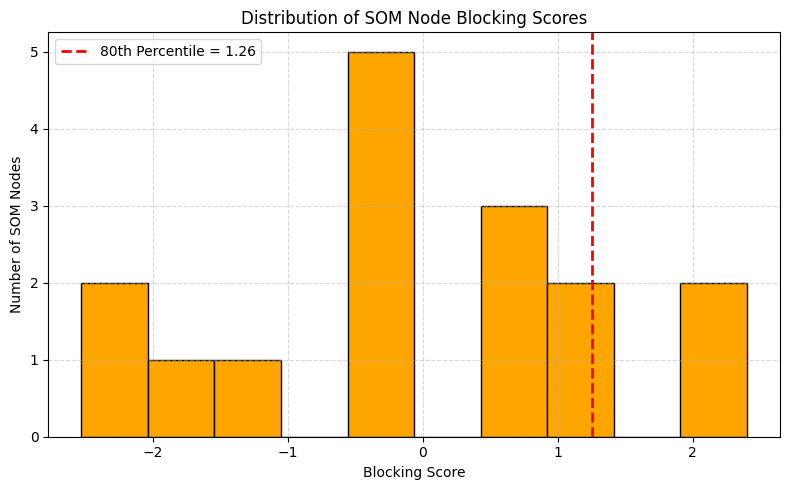

In [ ]:
#get blockingscore column from SOM data
blocking_scores = mean_features_scaled["blocking_score"]


plt.figure(figsize=(8, 5))

# plots histogram with blocking scores
n, bins, patches = plt.hist(blocking_scores, bins=10, color='orange', edgecolor='black')

# calculate blocking score threshold to plot
score_thresh = blocking_scores.quantile(0.80)
#draw dashed line along threshold to separate blocked (>80%) from not blocked
plt.axvline(score_thresh, color='red', linestyle='--', linewidth=2, label=f"80th Percentile = {score_thresh:.2f}")


plt.title("Distribution of SOM Node Blocking Scores")
plt.xlabel("Blocking Score")
plt.ylabel("Number of SOM Nodes")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(output_folder, "blocking_score_histogram.png"))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# generate labels
labels = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]

int_labels = LabelEncoder().fit_transform(labels)

sil_score = silhouette_score(X_scaled, int_labels)
print(f"Silhouette Score for SOM Node Clustering: {sil_score:.2f}")

Silhouette Score for SOM Node Clustering: 0.32


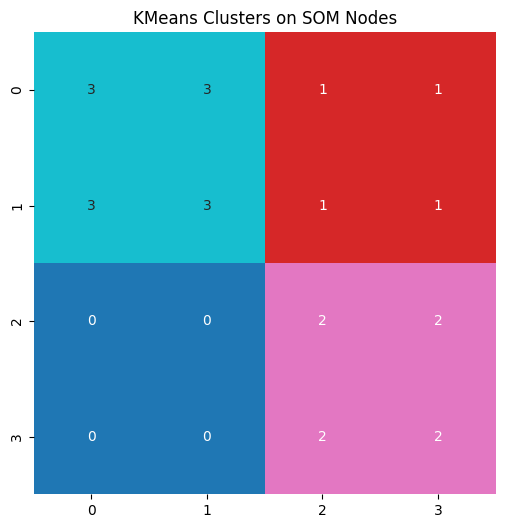

Calinski-Harabasz Score: 17.67
Davies-Bouldin Index: 0.68


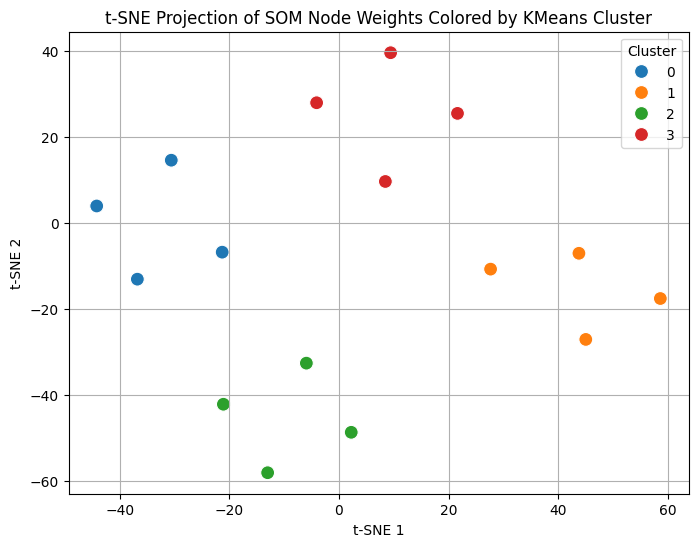

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import seaborn as sns
from collections import Counter

# Flatten SOM weights for clustering
weights = som.get_weights()
weights_flat = weights.reshape(-1, weights.shape[-1])

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans_labels = kmeans.fit_predict(weights_flat)

# Reshape labels to SOM grid
kmeans_labels_grid = kmeans_labels.reshape(weights.shape[0], weights.shape[1])

# Plot SOM nodes colored by KMeans cluster
plt.figure(figsize=(6, 6))
sns.heatmap(kmeans_labels_grid, annot=True, cmap='tab10', cbar=False, square=True)
plt.title('KMeans Clusters on SOM Nodes')
plt.savefig(os.path.join(output_folder, "kmeans_on_som_node.png"))
plt.show()

# Evaluate clustering quality
ch_score = calinski_harabasz_score(weights_flat, kmeans_labels)
dbi_score = davies_bouldin_score(weights_flat, kmeans_labels)
print(f"Calinski-Harabasz Score: {ch_score:.2f}")
print(f"Davies-Bouldin Index: {dbi_score:.2f}")

# t-SNE projection of SOM weights
tsne = TSNE(n_components=2, random_state=0, perplexity=5)
weights_tsne = tsne.fit_transform(weights_flat)

# Plot t-SNE with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=weights_tsne[:, 0], y=weights_tsne[:, 1], hue=kmeans_labels, palette='tab10', s=100)
plt.title('t-SNE Projection of SOM Node Weights Colored by KMeans Cluster')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(os.path.join(output_folder, "tSNE_kmeans.png"))
plt.show()


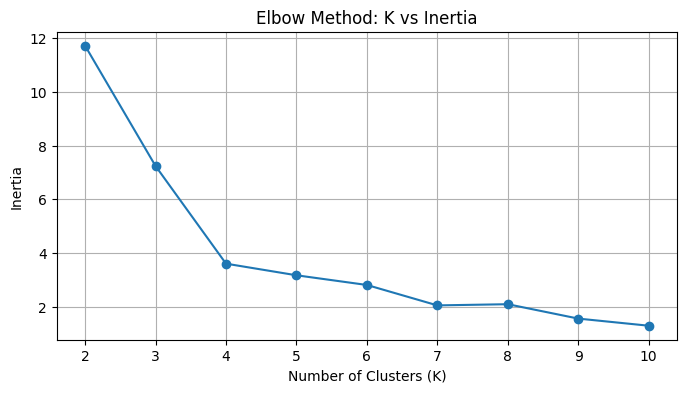

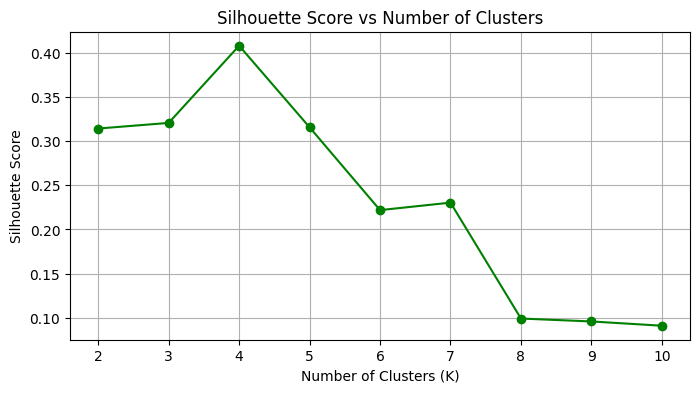

In [ ]:
from sklearn.metrics import silhouette_score

k_range = range(2, 11)
inertias = []
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(weights_flat)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(weights_flat, labels))

# Plot Elbow Method (Inertia)
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method: K vs Inertia')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig(os.path.join(output_folder, "elbow_method_kmeans.png"))
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 4))
plt.plot(k_range, sil_scores, marker='o', color='green')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')

plt.grid(True)
plt.savefig(os.path.join(output_folder, "sil_score_soms.png"))
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# JET01-01
def test_dataset_opens(ds):
    """Check if dataset is opened correctly as an xarray.Dataset."""
    assert isinstance(ds, xr.Dataset)

def test_variable_presence(ds):
    """Check that required variables 'pv' and 'z' are present in dataset."""
    assert 'pv' in ds.data_vars and 'z' in ds.data_vars

def test_coordinate_dimensions(ds):
    """Verify that dataset includes the required coordinates."""
    for coord in ['valid_time', 'latitude', 'longitude']:
        assert coord in ds.coords

def test_pressure_level_value(ds):
    """Check that the pressure level is 500 hPa."""
    assert ds.pressure_level.values[0] == 500.0


# JET02-01

def test_unit_conversion(ds):
    """Test that z and pv variables are converted to correct units without NaNs."""
    z500 = ds['z'] / 9.80665
    pv_pvu = ds['pv'].squeeze() * 1e6
    assert np.isfinite(z500.values).all()
    assert np.isfinite(pv_pvu.values).all()


# JET04-01

def normalization_selection(pv_mean, z500_grad_mean):
    """Compare z-score vs min-max normalization based on standard deviation ratio."""
    X = np.stack([pv_mean, z500_grad_mean], axis=1)
    min_val = np.min(X)
    max_val = np.max(X)
    scale_factor = 100.0 / (max_val - min_val)
    X_minmax = X * scale_factor
    X_zscore = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    std_ratio_minmax = np.std(X_minmax[:, 0]) / np.std(X_minmax[:, 1])
    std_ratio_zscore = np.std(X_zscore[:, 0]) / np.std(X_zscore[:, 1])
    return 'minmax' if abs(std_ratio_minmax - 1) < abs(std_ratio_zscore - 1) else 'zscore'


# JET07-01
def test_bmu_labeling(bmus):
    """Ensure that BMU labels are correctly formatted as 'x_y'."""
    labels = [f"{bmu[0]}_{bmu[1]}" for bmu in bmus]
    assert all('_' in label for label in labels)


# JET10-01
def test_kmeans_clustering_metrics_on_blobs():
    """Test silhouette and Davies-Bouldin scores on synthetic clustered data."""
    from sklearn.datasets import make_blobs
    X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.5, random_state=42)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
    labels = kmeans.labels_
    sil_score = silhouette_score(X, labels)
    dbi_score = davies_bouldin_score(X, labels)
    assert sil_score > 0.5, f"Expected Silhouette > 0.5, got {sil_score}"
    assert dbi_score < 0.7, f"Expected DBI < 0.7, got {dbi_score}"